In [ ]:
!pip install -q xgboost

In [2]:
import kagglehub
import pandas as pd
import os
# Download latest version
path = kagglehub.dataset_download("arshkon/linkedin-job-postings")
df = pd.read_csv(os.path.join(path,"postings.csv"))

In [3]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
t5_model = SentenceTransformer('sentence-transformers/sentence-t5-base')

# Sentences we want to encode. Example:
sentence = ['This framework generates embeddings for each input sentence']

# Sentences are encoded by calling model.encode()
embedding = t5_model.encode(sentence)

In [4]:
# Drop NA
salary_df = df[df["max_salary"].notna() & df["min_salary"].notna() & df["description"].notna()]

# Convert Salary
salary_scale = {
    "HOURLY": 2080,
    "WEEKLY": 52,
    "BIWEEKLY": 26,
    "MONTHLY":12
}
for period, scale in salary_scale.items():
    salary_df.loc[salary_df['pay_period'] == period, 'max_salary'] *= scale
    salary_df.loc[salary_df['pay_period'] == period, 'min_salary'] *= scale
    salary_df.loc[salary_df['pay_period'] == period, 'pay_period'] = "YEARLY"

In [5]:
salary_df.head()
salary_df["total_text"] = salary_df["title"] + ' ' + salary_df["description"] + ' ' + salary_df["location"]


/var/folders/g9/m0c3tdxd4l7f9js2h3wz_fp40000gn/T/ipykernel_87443/3107211692.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  salary_df["total_text"] = salary_df["title"] + ' ' + salary_df["description"] + ' ' + salary_df["location"]


In [6]:
salary_df["total_text_embedding"] = salary_df["total_text"].apply(lambda x: model.encode(x))


KeyboardInterrupt



In [ ]:
len(salary_df["title_embedding"][0])

In [ ]:
embedding_df = pd.DataFrame(salary_df.total_text_embedding.tolist(), index= salary_df.index)
# salary_df["title_embedding"].expand()

In [ ]:
embedding_df.head()

# Train

In [7]:
embedding_df.to_csv("paraphrase_total-result.csv")

NameError: name 'embedding_df' is not defined

In [9]:
embedding_df = pd.read_csv("linkedin_embeddings/paraphrase_total-result.csv")

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(embedding_df.to_numpy(),salary_df["max_salary"].to_numpy())

In [11]:
# from sklearn.ensemble import GradientBoostingRegressor
# clf = GradientBoostingRegressor(n_estimators=500, max_depth=5, random_state=0)

import xgboost as xg 

clf = xg.XGBRegressor(objective ='reg:squarederror', n_estimators = 500, max_depth=5, seed = 123)
clf.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [12]:
y_pred = clf.predict(X_test)

In [23]:
type(X_test)

numpy.ndarray

8619579.962875325


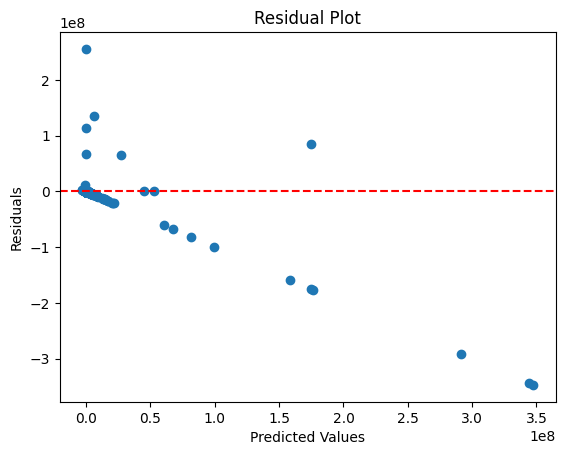

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error

# scale = 1
# y_pred_scale = y_pred / scale
residuals = y_test - y_pred

# filter_idx = (residuals < 1e7) & (residuals > -3e7)
# filter_idx = (residuals < 5e7) & (residuals > -5e7)
# filter_idx = (residuals > -1e5)

# rmse = root_mean_squared_error(y_pred_scale[filter_idx], y_test[filter_idx])
rmse = root_mean_squared_error(y_pred, y_test)
print(rmse)

# residuals[residuals < 5e7]
# Plot the residuals
# plt.scatter(y_pred_scale[filter_idx], residuals[filter_idx])
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

In [17]:
pd.DataFrame(residuals).describe()

,0
count,7.448000e+03
mean,-2.100287e+05
std,8.617599e+06
min,-3.473815e+08
25%,-3.885016e+04
50%,-2.900430e+03
75%,3.243338e+04
max,2.559365e+08
